Here I will illustrate the steps needed to fit the behavioural model to empirical data. This entails determining the posterior beleifs over model parameters and mini-block specific planning depth.

In [1]:
import torch

from scipy import io

import pandas as pd

from torch import zeros, ones

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context = 'talk', style = 'white')
sns.set_palette("colorblind", n_colors=5, color_codes=True)

# function for plotting asymetric errorbars
def errorplot(*args, **kwargs):
    subjects = args[0]
    values = args[1].values
    
    unique_subjects = np.unique(subjects)
    nsub = len(unique_subjects)
    
    values = values.reshape(-1, nsub)
    
    quantiles = np.percentile(values, [5, 50, 95], axis=0)
    
    low_perc = quantiles[0]
    up_perc = quantiles[-1]
    
    x = unique_subjects
    y = quantiles[1]

    assert np.all(low_perc <= y)
    assert np.all(y <= up_perc)
    
    kwargs['yerr'] = [y-low_perc, up_perc-y]
    kwargs['linestyle'] = ''
    kwargs['marker'] = 'o'
    
    plt.errorbar(x, y, **kwargs)
    
# function for mapping strings ('high', 'low') to numbers 0, 1

def map_noise_to_values(strings):
    for s in strings:
        if s[0] == 'high':
            yield 1
        elif s[0] == 'low':
            yield 0
        else:
            yield np.nan

In [2]:
from pathlib import Path
from os import listdir
    
def load_and_format_behavioural_data(local_path, cuttoff=0):
    
    path = local_path
    fnames = listdir(path)
    
    runs = len(fnames)  # number of subjects
    
    mini_blocks = 100  # number of mini blocks in each run
    max_trials = 3  # maximal number of trials within a mini block
    max_depth = 3  # maximal planning depth

    na = 2  # number of actions
    ns = 6 # number of states/locations
    no = 5 # number of outcomes/rewards

    responses = []
    states = []
    scores = []
    conditions = [[], []]
    confs = [] 
    ids = []
    for i,f in enumerate(fnames):
        parts = f.split('_')
        tmp = io.loadmat(path+f)
        scores.append(torch.from_numpy(tmp['data']['Points'][0,0]))
        if np.nan_to_num(scores[-1][-1, 0]) > cuttoff:
            responses.append(torch.from_numpy(tmp['data']['Responses'][0,0]['Keys'][0,0]-1))
            states.append(torch.from_numpy(tmp['data']['States'][0,0] - 1).long())
            confs.append(torch.from_numpy(tmp['data']['PlanetConf'][0,0] - 1).long())
            strings = tmp['data']['Conditions'][0,0]['noise'][0,0][0]
            conditions[0].append(torch.tensor(list(map_noise_to_values(strings)), dtype=torch.long))
            conditions[1].append(torch.from_numpy(tmp['data']['Conditions'][0,0]['notrials'][0,0][:,0]).long())
            ids.append(parts[1])
    
    states = torch.stack(states, 0)
    states[states < 0] = -1
    confs = torch.eye(no)[torch.stack(confs, 0)]
    conditions = torch.stack([torch.stack(conditions[0], 0), torch.stack(conditions[1], 0)], 0)
    # define dictionary containing information which participants recieved on each trial
    stimuli = {'conditions': conditions,
               'states': states, 
               'configs': confs}

    responses = torch.stack(responses, 0).float()
    mask = ~torch.isnan(responses)
    
    return stimuli, mask, responses, conditions, ids

In [3]:
# load and format behavioural data
path = 'data/'

stimuli, mask, responses, conditions, ids = load_and_format_behavioural_data(path)

In [4]:
from pybefit.agents.torch import VISAT
from pybefit.inference.pyro import NormalGammaDiscreteDepth

def variational_inference(stimuli, mask, responses):
    max_depth = 3
    mini_blocks, max_trials, runs = responses.shape
    
    confs = stimuli['configs']
    
    # define value iteration agent for the space adventure task
    agent = VISAT(confs,
                  runs=runs,
                  mini_blocks=mini_blocks,
                  trials=max_trials,
                  planning_depth=max_depth)

    # load inference module and start model fitting
    infer = NormalGammaDiscreteDepth(agent, stimuli, responses, mask)
    infer.infer_posterior(iter_steps=2000, num_particles=10, optim_kwargs={'lr': 0.01})
    
    return infer

In [5]:
# Variational inference
# responses should have the shape n_blocks, n_trials, n_subjects
infer = variational_inference(stimuli, mask, responses.permute(1, 2, 0))

labels = [r'$\beta$', r'$\theta$', r'$\alpha$']
_, pars_df, mg_df, sg_df = infer.sample_posterior(labels)
pars_df = pars_df.melt(id_vars=['subject'], var_name='parameter')

n_samples = 100
post_marg = infer.sample_posterior_marginal(n_samples=n_samples)
pars_df['IDs'] = np.array(ids)[pars_df.subject.values - 1]
# pars_df.to_csv('pars_post_samples_main.csv')

Sample posterior discrete marginal: 100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


The static parametrisations assumes that the planning depth at the start of every mini block is sampled from the same prior distribution (dependent on the number of choices, 2 or 3), independent on the planning depth in the previous trial. Alternative is to use dynamic parametrisation where planning depth is describes as a hidden markov or hidden semi-markov process. The dynamic representation would be useful to quantify the stability of planning depths within and between groups. For example, certain group of participants might be charachtersied by more varying planning depth between trials than other. Unfortuntaly, I still have problems inferring the parameters of a dynamic representations. 

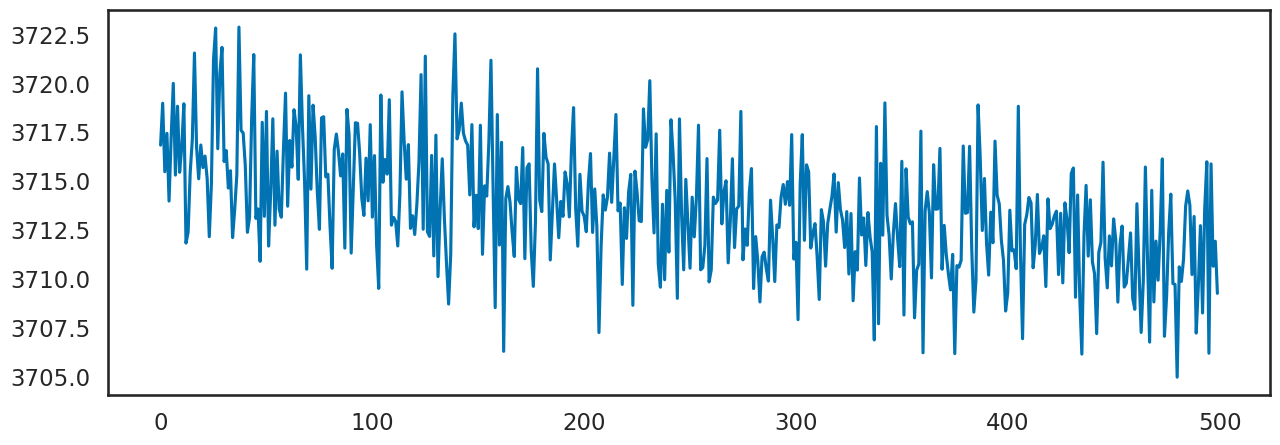

In [11]:
# plot convergence of ELBO bound (approximate value of the negative marginal log likelihood)
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
axes.plot(infer.loss[-500:]);

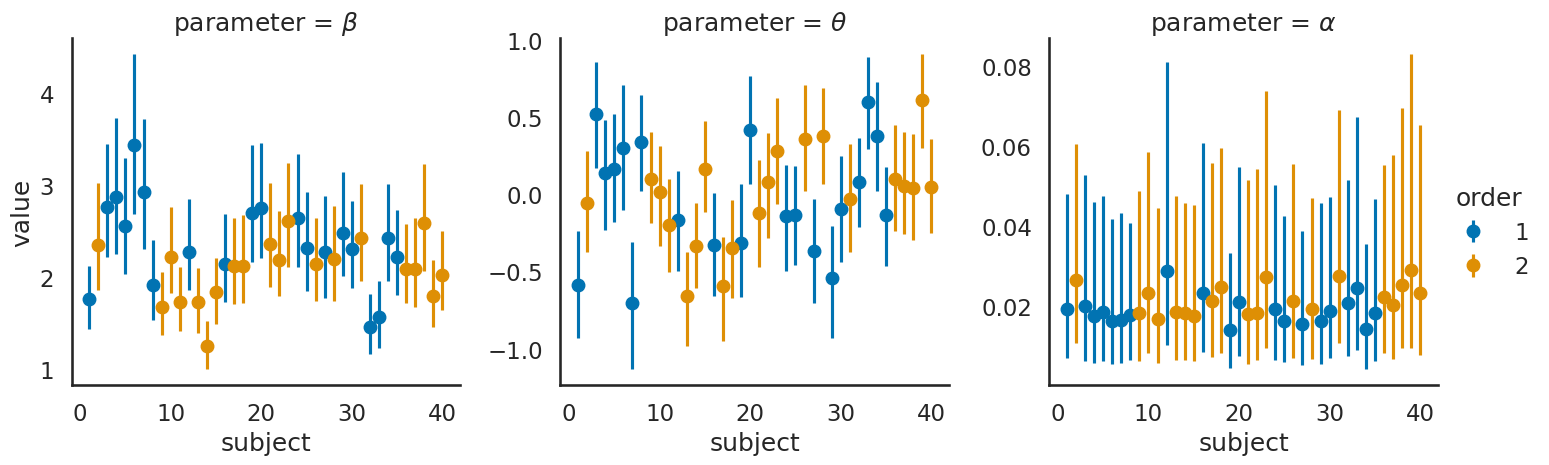

In [12]:
# number of trials in the first mini-block
max_trials = conditions[-1, :, 0]
order = (max_trials == 3) + 1
pars_df['order'] = order[pars_df.subject - 1]

# visualize posterior parameter estimates over subjects
g = sns.FacetGrid(pars_df, col="parameter", hue='order', height=5, sharey=False);
g = g.map(errorplot, 'subject', 'value').add_legend();

In what follows we will compute the posterior marginal over planning depth, compute exceedanace probability and plot the results for individual subjects and for the group level results.

In [13]:
def get_posterior_stats(post_marg, mini_blocks=100):
    n_samples, runs, max_trials = post_marg['d_0_0'].shape
    post_depth = {0: np.zeros((n_samples, mini_blocks, runs, max_trials)),
              1: np.zeros((n_samples, mini_blocks, runs, max_trials))}
    for pm in post_marg:
        b, t = np.array(pm.split('_')[1:]).astype(int)
        if t in post_depth:
            post_depth[t][:, b] = post_marg[pm]

    # get sample mean over planning depth for the first and second choice
    m_prob = [post_depth[c].mean(0) for c in range(2)]

    # get sample plannign depth exceedance count of the first and second choice
    # exceedance count => number of times planning depth d had highest posterior probability
    exc_count = [np.array([np.sum(post_depth[t].argmax(-1) == i, 0) for i in range(3)]) for t in range(2)]
    
    return post_depth, m_prob, exc_count

post_depth, m_prob, exc_count = get_posterior_stats(post_marg)
# np.savez('plandepth_stats_main', post_depth=post_depth, m_prob=m_prob, exc_count=exc_count)

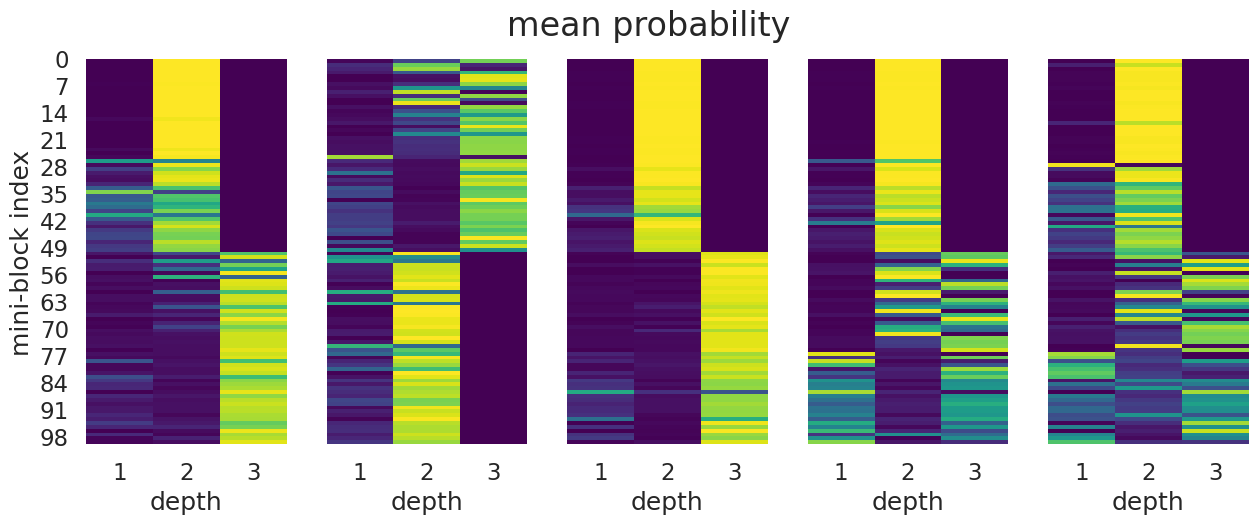

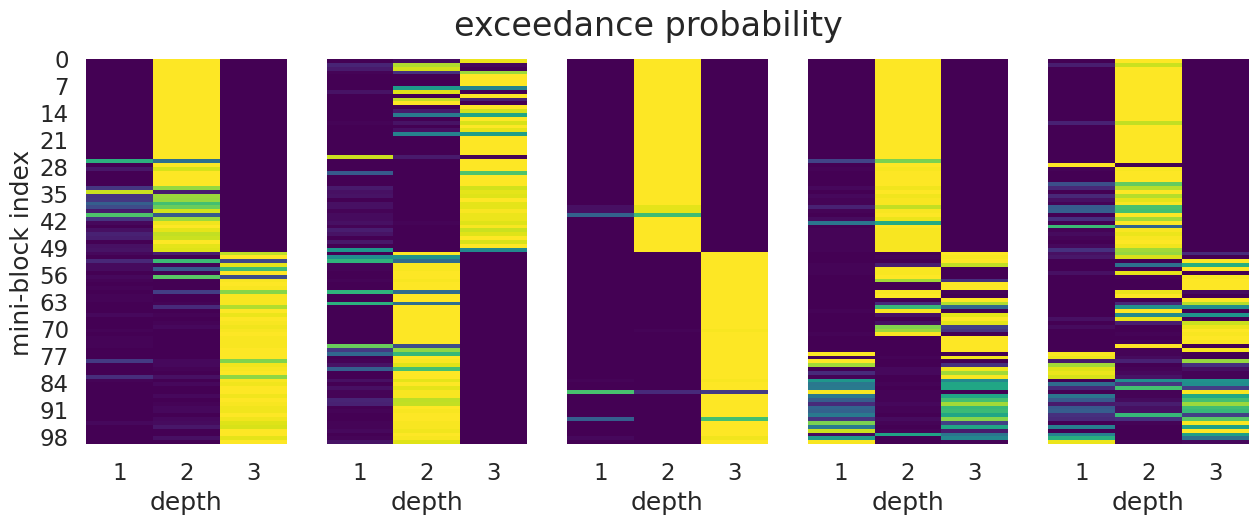

In [14]:
# plot true planning depth and estimated mean posterior depth of the first choice for two runs (one from each group)
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharex=True, sharey=True)

for ns, ax in zip(range(5), axes):
    sns.heatmap(m_prob[0][:, ns], cmap='viridis', ax=ax, cbar=False)
    ax.set_xticklabels([1, 2, 3])
    ax.set_xlabel('depth')
    
axes[0].set_ylabel('mini-block index')
fig.suptitle('mean probability', fontsize=24)

# plot true planning depth and depth exceedance probability of the first choice for two runs (one from each group)
# plot true planning depth and estimated mean posterior depth of the first choice for two runs (one from each group)
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharex=True, sharey=True)

for ns, ax in zip(range(5), axes):
    sns.heatmap(exc_count[0][..., ns].T/n_samples, cmap='viridis', ax=ax, cbar=False)
    ax.set_xticklabels([1, 2, 3])
    ax.set_xlabel('depth')

axes[0].set_ylabel('mini-block index')
fig.suptitle('exceedance probability', fontsize=24);

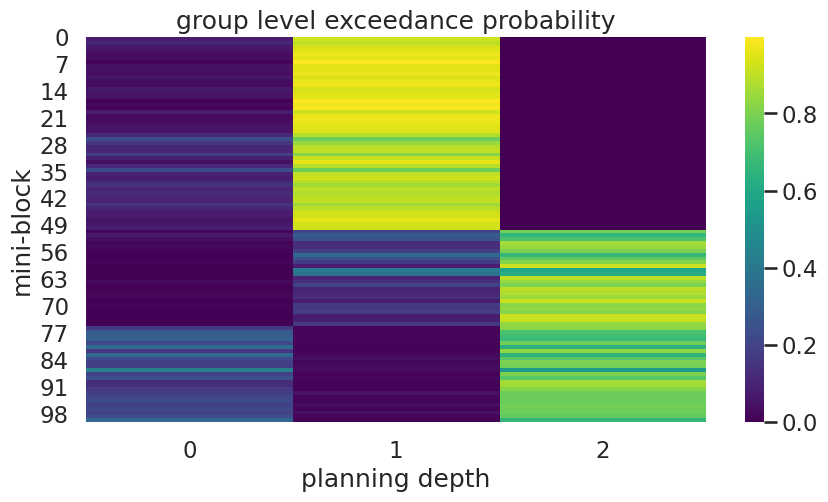

In [15]:
# plot group level exceedance probability
def group_level_EP(exc_count, conditions):
    _, n_samples, runs = exc_count[0].shape
    order = conditions[-1, :, 0].numpy() == 2
    ordered_exc_count = np.concatenate([exc_count[0][..., order], 
                                        np.concatenate([exc_count[0][:, 50:, ~order], 
                                                        exc_count[0][:, :50, ~order]], -2)],
                                        -1
                                       )
    return ordered_exc_count.sum(-1)/(n_samples*runs)

ep = group_level_EP(exc_count, conditions)

plt.figure(figsize=(10, 5))
sns.heatmap(ep.T, cmap='viridis')
plt.xlabel('planning depth');
plt.ylabel('mini-block');
plt.title('group level exceedance probability');